In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Final Project/DataSet/thinking.csv')

X = df[['F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4']]
y = df['Label'] 
y = pd.factorize(y)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)


In [3]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return LayerNormalization(epsilon=1e-6)(x + res) 


In [4]:

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_classes, num_blocks, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation="softmax")(x) 
    return Model(inputs, outputs)


In [5]:

input_shape = X_train.shape[1:] 
num_classes = len(np.unique(y))

transformer_model = build_transformer_model(
    input_shape=input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=64,
    num_classes=num_classes,
    num_blocks=2,
    dropout=0.1,
)


transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [6]:

history = transformer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10752/10752 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.0619 - loss: 2.7774 - val_accuracy: 0.0626 - val_loss: 2.7726
Epoch 2/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 74s 4ms/step - accuracy: 0.0622 - loss: 2.7728 - val_accuracy: 0.0628 - val_loss: 2.7728
Epoch 3/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.0634 - loss: 2.7728 - val_accuracy: 0.0628 - val_loss: 2.7728
Epoch 4/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.0608 - loss: 2.7728 - val_accuracy: 0.0613 - val_loss: 2.7727
Epoch 5/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.0623 - loss: 2.7728 - val_accuracy: 0.0623 - val_loss: 2.7728
Epoch 6/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.0620 - loss: 2.7728 - val_accuracy: 0.0619 - val_loss: 2.7728
Epoch 7/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.0625 - loss: 2.7727 - val_accuracy: 0.0628 - val_loss: 2.7726
Epoch 8/10
10752/10752 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.0623 - lo

In [7]:

y_pred_proba = transformer_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


5760/5760 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Accuracy: 0.0619140625
Precision: 0.0038333511352539058
Recall (Sensitivity): 0.0619140625
F1 Score: 0.007219701236895347
Confusion Matrix:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11593]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11633]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11404]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11567]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11409]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11507]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11520]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 11562]
 [    0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


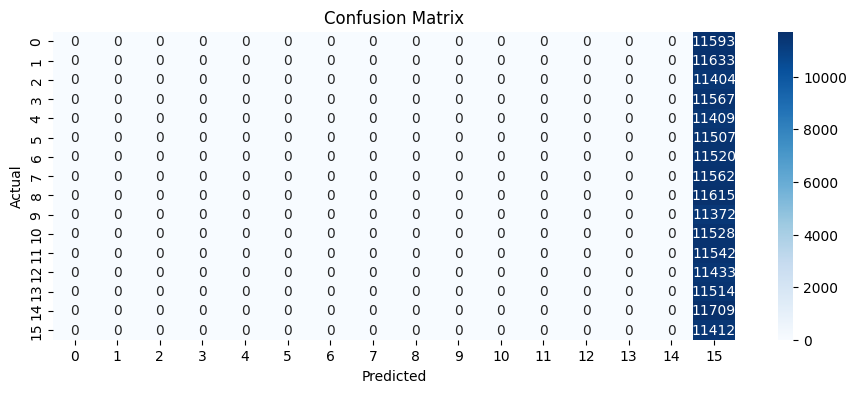

In [9]:
#Confusion Matrix
plt.figure(figsize=(11, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


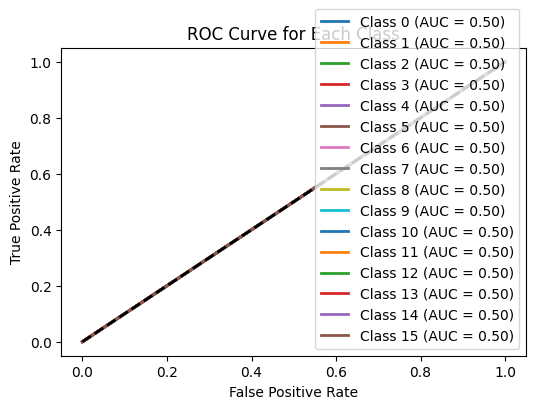

In [12]:
#ROC Curve
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.unique(y))

plt.figure(figsize=(6, 4))
for i in range(len(np.unique(y))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()


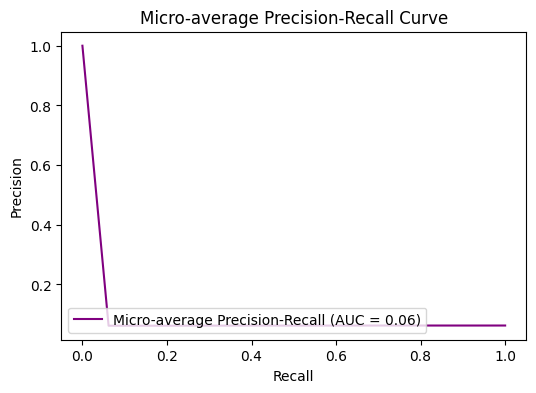

In [13]:
#PR Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
average_precision = average_precision_score(y_test_bin, y_pred_proba, average="micro")

plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, color='purple', label=f"Micro-average Precision-Recall (AUC = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Micro-average Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


In [16]:

transformer_model.save('transformer_model.h5')


with open("Transformer_model_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n")
    f.write(f"Precision: {precision}\n")
    f.write(f"Recall (Sensitivity): {recall}\n")
    f.write(f"F1 Score: {f1}\n")
    f.write(f"Confusion Matrix:\n{conf_matrix}\n")
